In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
import matplotlib.dates as mdates

----------------------------------------------------------------------------------------------------------------
Two types of files downloaded: HourlyAQ and HourlyData

----------------------------------------------------------

In [3]:
# read in the two types of files from root directory

dir = "F:/RMonaghan_Workspace/Projects/Albany_Smoke"

aq_files = [
    os.path.join(r, file).replace("\\", "/")
    for r, d, f in os.walk(dir)
    for file in f
    if file.startswith("HourlyAQ") & file.endswith(".dat")
]
hourly_data_files = [
    os.path.join(r, file).replace("\\", "/")
    for r, d, f in os.walk(dir)
    for file in f
    if file.startswith("HourlyData") & file.endswith(".dat")
]

len(aq_files), len(hourly_data_files)

(5272, 5272)

In [31]:
# concatenate
# subset Albany sensor

aq_df = pd.concat(
    [pd.read_table(i, sep=",").query('AQSID =="130950007"') for i in aq_files]
)

cols = [
    "Date",
    "Time",
    "AQSID",
    "POI",
    "Unknown",
    "AQI",
    "Unit",
    "Value",
    "Monitoring_Network",
]
hourly_data_df = pd.concat(
    [
        pd.read_table(i, sep="|", names=cols).query('AQSID =="130950007"')
        for i in hourly_data_files
    ]
)

In [33]:
aq_df.to_csv("Albany_Composite_CSVs/Albany_HourlyAQ.csv")
hourly_data_df.to_csv("Albany_Composite_CSVs/Albany_HourlyData.csv")

In [2]:
aq = pd.read_csv("F:/RMonaghan_Workspace/Projects/Albany_Smoke/Albany_Composite_CSVs/Albany_HourlyAQ.csv")
print(aq.shape)
print(aq.columns)
aq.head()

(5271, 35)
Index(['Unnamed: 0', 'AQSID', 'SiteName', 'Status', 'EPARegion', 'Latitude',
       'Longitude', 'Elevation', 'GMTOffset', 'CountryCode', 'StateName',
       'ValidDate', 'ValidTime', 'DataSource', 'ReportingArea_PipeDelimited',
       'OZONE_AQI', 'PM10_AQI', 'PM25_AQI', 'NO2_AQI', 'OZONE_Measured',
       'PM10_Measured', 'PM25_Measured', 'NO2_Measured', 'NO2', 'NO2_Unit',
       'CO', 'CO_Unit', 'PM25', 'PM25_Unit', 'SO2', 'SO2_Unit', 'OZONE',
       'OZONE_Unit', 'PM10', 'PM10_Unit'],
      dtype='object')


Unnamed: 0      AQSID SiteName  Status EPARegion  Latitude  Longitude  \
0        1452  130950007   Albany  Active        R4   31.5767   -84.1002   
1        3721  130950007   Albany  Active        R4   31.5767   -84.1002   
2        4806  130950007   Albany  Active        R4   31.5767   -84.1002   
3        2959  130950007   Albany  Active        R4   31.5767   -84.1002   
4        3058  130950007   Albany  Active        R4   31.5767   -84.1002   

   Elevation  GMTOffset CountryCode  ...  CO CO_Unit   PM25 PM25_Unit SO2  \
0       66.8       -5.0          US  ... NaN     NaN    4.5     UG/M3 NaN   
1       66.8       -5.0          US  ... NaN     NaN    NaN       NaN NaN   
2       66.8       -5.0          US  ... NaN     NaN    8.7     UG/M3 NaN   
3       66.8       -5.0          US  ... NaN     NaN  111.1     UG/M3 NaN   
4       66.8       -5.0          US  ... NaN     NaN   11.0     UG/M3 NaN   

   SO2_Unit  OZONE  OZONE_Unit   PM10  PM10_Unit  
0       NaN    NaN         NaN    7.0      UG/M3  
1       NaN    NaN         NaN   38.0      UG/M3  
2       NaN    NaN         NaN   18.0      UG/M3  
3       NaN    NaN         NaN  138.0      UG/M3  
4       NaN    NaN         NaN   16.0      UG/M3  

[5 rows x 35 columns]

In [7]:
# creating DT object
# converting TZ to Albany local (ET)

aq['DT'] = aq['ValidDate'] + 'T' + aq['ValidTime']
aq['DT'] = pd.to_datetime(aq['DT'], utc=True)
aq.set_index('DT', inplace=True)
aq = aq.tz_convert('US/Eastern')
aq

Unnamed: 0      AQSID SiteName  Status EPARegion  \
DT                                                                            
2023-01-13 10:00:00-05:00        1452  130950007   Albany  Active        R4   
2023-04-20 20:00:00-04:00        3721  130950007   Albany  Active        R4   
2023-05-03 03:00:00-04:00        4806  130950007   Albany  Active        R4   
2023-03-16 01:00:00-04:00        2959  130950007   Albany  Active        R4   
2023-01-21 19:00:00-05:00        3058  130950007   Albany  Active        R4   
...                               ...        ...      ...     ...       ...   
2023-03-22 14:00:00-04:00        1718  130950007   Albany  Active        R4   
2022-11-24 14:00:00-05:00         207  130950007   Albany  Active        R4   
2023-03-18 05:00:00-04:00         610  130950007   Albany  Active        R4   
2023-02-03 03:00:00-05:00         403  130950007   Albany  Active        R4   
2023-05-05 14:00:00-04:00          25  130950007   Albany  Active        R4   

                           Latitude  Longitude  Elevation  GMTOffset  \
DT                                                                     
2023-01-13 10:00:00-05:00   31.5767   -84.1002       66.8       -5.0   
2023-04-20 20:00:00-04:00   31.5767   -84.1002       66.8       -5.0   
2023-05-03 03:00:00-04:00   31.5767   -84.1002       66.8       -5.0   
2023-03-16 01:00:00-04:00   31.5767   -84.1002       66.8       -5.0   
2023-01-21 19:00:00-05:00   31.5767   -84.1002       66.8       -5.0   
...                             ...        ...        ...        ...   
2023-03-22 14:00:00-04:00   31.5767   -84.1002       66.8       -5.0   
2022-11-24 14:00:00-05:00   31.5767   -84.1002       66.8       -5.0   
2023-03-18 05:00:00-04:00   31.5767   -84.1002       66.8       -5.0   
2023-02-03 03:00:00-05:00   31.5767   -84.1002       66.8       -5.0   
2023-05-05 14:00:00-04:00   31.5767   -84.1002       66.8       -5.0   

                          CountryCode  ...  CO CO_Unit   PM25 PM25_Unit SO2  \
DT                                     ...                                    
2023-01-13 10:00:00-05:00          US  ... NaN     NaN    4.5     UG/M3 NaN   
2023-04-20 20:00:00-04:00          US  ... NaN     NaN    NaN       NaN NaN   
2023-05-03 03:00:00-04:00          US  ... NaN     NaN    8.7     UG/M3 NaN   
2023-03-16 01:00:00-04:00          US  ... NaN     NaN  111.1     UG/M3 NaN   
2023-01-21 19:00:00-05:00          US  ... NaN     NaN   11.0     UG/M3 NaN   
...                               ...  ...  ..     ...    ...       ...  ..   
2023-03-22 14:00:00-04:00          US  ... NaN     NaN    8.7     UG/M3 NaN   
2022-11-24 14:00:00-05:00          US  ... NaN     NaN    9.8     UG/M3 NaN   
2023-03-18 05:00:00-04:00          US  ... NaN     NaN    5.3     UG/M3 NaN   
2023-02-03 03:00:00-05:00          US  ... NaN     NaN    1.3     UG/M3 NaN   
2023-05-05 14:00:00-04:00          US  ... NaN     NaN   10.1     UG/M3 NaN   

                           SO2_Unit  OZONE  OZONE_Unit   PM10  PM10_Unit  
DT                                                                        
2023-01-13 10:00:00-05:00       NaN    NaN         NaN    7.0      UG/M3  
2023-04-20 20:00:00-04:00       NaN    NaN         NaN   38.0      UG/M3  
2023-05-03 03:00:00-04:00       NaN    NaN         NaN   18.0      UG/M3  
2023-03-16 01:00:00-04:00       NaN    NaN         NaN  138.0      UG/M3  
2023-01-21 19:00:00-05:00       NaN    NaN         NaN   16.0      UG/M3  
...                             ...    ...         ...    ...        ...  
2023-03-22 14:00:00-04:00       NaN    NaN         NaN   16.0      UG/M3  
2022-11-24 14:00:00-05:00       NaN    NaN         NaN   18.0      UG/M3  
2023-03-18 05:00:00-04:00       NaN    NaN         NaN    9.0      UG/M3  
2023-02-03 03:00:00-05:00       NaN    NaN         NaN    2.0      UG/M3  
2023-05-05 14:00:00-04:00       NaN    NaN         NaN   27.0      UG/M3  

[5271 rows x 35 columns]

In [57]:
hd = pd.read_csv("F:/RMonaghan_Workspace/Projects/Albany_Smoke/Albany_Composite_CSVs/Albany_HourlyData.csv")
print(hd.shape)
print(hd.columns)
hd.head()

(9439, 10)
Index(['Unnamed: 0', 'ValidDate', 'ValidTime', 'AQSID', 'sitename',
       'GMT offset', 'parameter name', 'reporting units', 'value',
       'data source'],
      dtype='object')


Unnamed: 0  ValidDate ValidTime      AQSID sitename  GMT offset  \
0        2454  1/25/2023     19:00  130950007   Albany          -5   
1        2455  1/25/2023     19:00  130950007   Albany          -5   
2        2507  3/20/2023      9:00  130950007   Albany          -5   
3        2508  3/20/2023      9:00  130950007   Albany          -5   
4        2507  4/26/2023     19:00  130950007   Albany          -5   

  parameter name reporting units  value  \
0           PM10           UG/M3   11.0   
1          PM2.5           UG/M3    4.5   
2           PM10           UG/M3   14.0   
3          PM2.5           UG/M3    9.5   
4           PM10           UG/M3   38.0   

                               data source  
0  Georgia Department of Natural Resources  
1  Georgia Department of Natural Resources  
2  Georgia Department of Natural Resources  
3  Georgia Department of Natural Resources  
4  Georgia Department of Natural Resources

In [58]:
# creating DT object
# adding 5 hours to UTC DT to make ET

hd['DT'] = hd['ValidDate'] + 'T' + hd['ValidTime'] 
hd['DT'] = pd.to_datetime(hd['DT'], utc=True)
hd['DT'] = hd['DT'] - pd.Timedelta(hours=5)
hd.sort_values('DT', inplace=True)

In [59]:
hd.rename(columns={'parameter name':'ParameterName', 'Value':'Value'}, inplace=True)

In [13]:
hd['Day'] = hd['DT'].dt.dayofyear

Unnamed: 0   ValidDate ValidTime      AQSID sitename  GMT offset  \
2995        2288  11/14/2022      5:00  130950007   Albany          -5   
2996        2289  11/14/2022      5:00  130950007   Albany          -5   
6668        2485  11/14/2022      6:00  130950007   Albany          -5   
6667        2484  11/14/2022      6:00  130950007   Albany          -5   
8549        2492  11/14/2022      7:00  130950007   Albany          -5   
...          ...         ...       ...        ...      ...         ...   
6378        2575   6/22/2023     13:00  130950007   Albany          -5   
6292        2564   6/22/2023     14:00  130950007   Albany          -5   
6291        2563   6/22/2023     14:00  130950007   Albany          -5   
9092        2451   6/22/2023     15:00  130950007   Albany          -5   
9093        2452   6/22/2023     15:00  130950007   Albany          -5   

     ParameterName reporting units  value  \
2995          PM10           UG/M3   12.0   
2996         PM2.5           UG/M3    7.7   
6668         PM2.5           UG/M3    8.2   
6667          PM10           UG/M3   12.0   
8549          PM10           UG/M3   12.0   
...            ...             ...    ...   
6378          PM10           UG/M3   13.0   
6292         PM2.5           UG/M3    7.7   
6291          PM10           UG/M3   16.0   
9092          PM10           UG/M3   13.0   
9093         PM2.5           UG/M3    7.4   

                                  data source                  DT  Day  
2995  Georgia Department of Natural Resources 2022-11-14 05:00:00  318  
2996  Georgia Department of Natural Resources 2022-11-14 05:00:00  318  
6668  Georgia Department of Natural Resources 2022-11-14 06:00:00  318  
6667  Georgia Department of Natural Resources 2022-11-14 06:00:00  318  
8549  Georgia Department of Natural Resources 2022-11-14 07:00:00  318  
...                                       ...                 ...  ...  
6378  Georgia Department of Natural Resources 2023-06-22 13:00:00  173  
6292  Georgia Department of Natural Resources 2023-06-22 14:00:00  173  
6291  Georgia Department of Natural Resources 2023-06-22 14:00:00  173  
9092  Georgia Department of Natural Resources 2023-06-22 15:00:00  173  
9093  Georgia Department of Natural Resources 2023-06-22 15:00:00  173  

[9439 rows x 12 columns]

In [61]:
exceedance1 = hd[hd['DT'].between('2023-02-07', '2023-02-09')]
exceedance11 = exceedance1.query('ParameterName == "PM2.5"')

Text(0.5, 1.0, 'Exceedance 1: Hourly Data Observations for PM 2.5, Albany (02/06/2023 - 02/09/2023)')

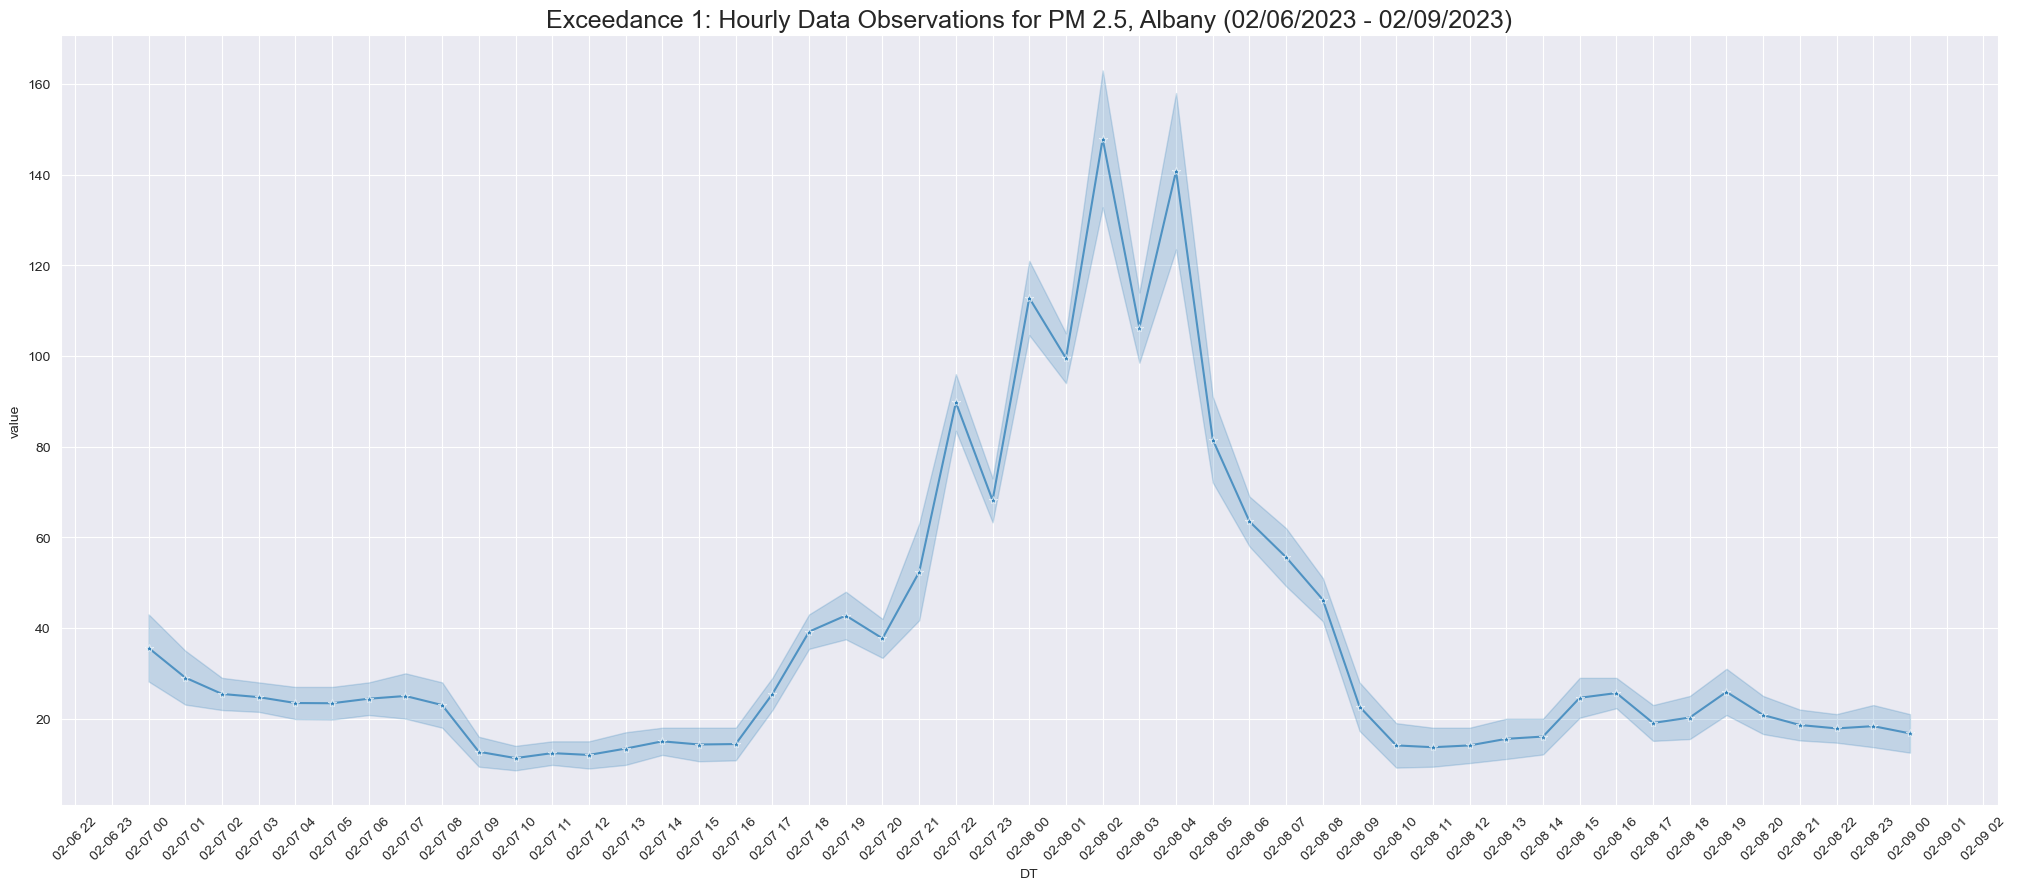

In [66]:
sns.set_style("darkgrid")

plt.figure(figsize=(25,10))
sns.lineplot(data=exceedance1, x='DT', y='value', alpha=0.7, marker = '*').set_title("Hourly Data Observations for PM 2.5, Albany (11/14/2022 - 06/22/2023)")
plt.xticks(rotation=45)
# plt.axhline(y=150, linestyle='dashed', color='red')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 
plt.title("Exceedance 1: Hourly Data Observations for PM 2.5, Albany (02/06/2023 - 02/09/2023)", fontsize=18)

In [29]:
exceedance2 = hd[hd['DT'].between('2023-03-15', '2023-03-17')]
exceedance2

Unnamed: 0  ValidDate ValidTime      AQSID sitename  GMT offset  \
8280        2494  3/15/2023      5:00  130950007   Albany          -5   
8279        2493  3/15/2023      5:00  130950007   Albany          -5   
160         2499  3/15/2023      6:00  130950007   Albany          -5   
161         2500  3/15/2023      6:00  130950007   Albany          -5   
3294        2510  3/15/2023      7:00  130950007   Albany          -5   
...          ...        ...       ...        ...      ...         ...   
9424        2540  3/17/2023      3:00  130950007   Albany          -5   
9201        2517  3/17/2023      4:00  130950007   Albany          -5   
9202        2518  3/17/2023      4:00  130950007   Albany          -5   
6121        2511  3/17/2023      5:00  130950007   Albany          -5   
6122        2512  3/17/2023      5:00  130950007   Albany          -5   

     parameter name reporting units  value  \
8280          PM2.5           UG/M3    6.3   
8279           PM10           UG/M3   10.0   
160            PM10           UG/M3   11.0   
161           PM2.5           UG/M3    7.9   
3294           PM10           UG/M3   11.0   
...             ...             ...    ...   
9424          PM2.5           UG/M3   31.4   
9201           PM10           UG/M3   36.0   
9202          PM2.5           UG/M3   28.0   
6121           PM10           UG/M3   42.0   
6122          PM2.5           UG/M3   32.5   

                                  data source                        DT  
8280  Georgia Department of Natural Resources 2023-03-15 00:00:00+00:00  
8279  Georgia Department of Natural Resources 2023-03-15 00:00:00+00:00  
160   Georgia Department of Natural Resources 2023-03-15 01:00:00+00:00  
161   Georgia Department of Natural Resources 2023-03-15 01:00:00+00:00  
3294  Georgia Department of Natural Resources 2023-03-15 02:00:00+00:00  
...                                       ...                       ...  
9424  Georgia Department of Natural Resources 2023-03-16 22:00:00+00:00  
9201  Georgia Department of Natural Resources 2023-03-16 23:00:00+00:00  
9202  Georgia Department of Natural Resources 2023-03-16 23:00:00+00:00  
6121  Georgia Department of Natural Resources 2023-03-17 00:00:00+00:00  
6122  Georgia Department of Natural Resources 2023-03-17 00:00:00+00:00  

[95 rows x 11 columns]

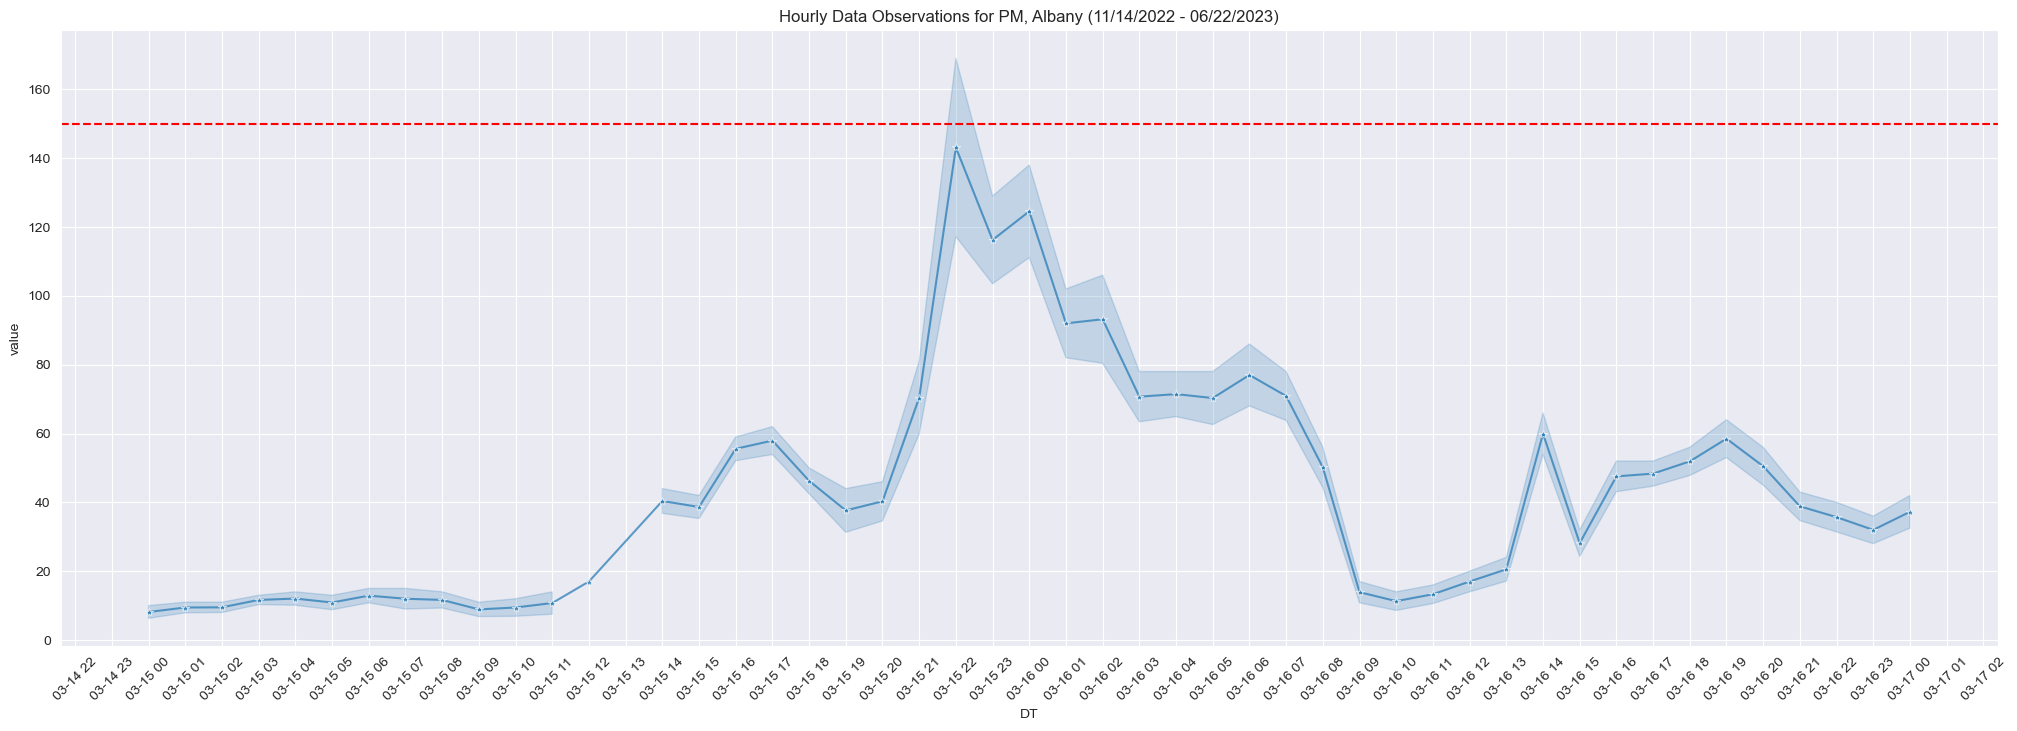

In [31]:
exceedance2 = hd[hd['DT'].between('2023-03-15', '2023-03-17')]
sns.set_style("darkgrid")

plt.figure(figsize=(25,8))
sns.lineplot(data=exceedance2, x='DT', y='value', alpha=0.7, linewidth=1.5, marker = '*').set_title("Hourly Data Observations for PM, Albany (11/14/2022 - 06/22/2023)")
plt.xticks(rotation=45)
plt.axhline(y=150, linestyle='dashed', color='red')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 

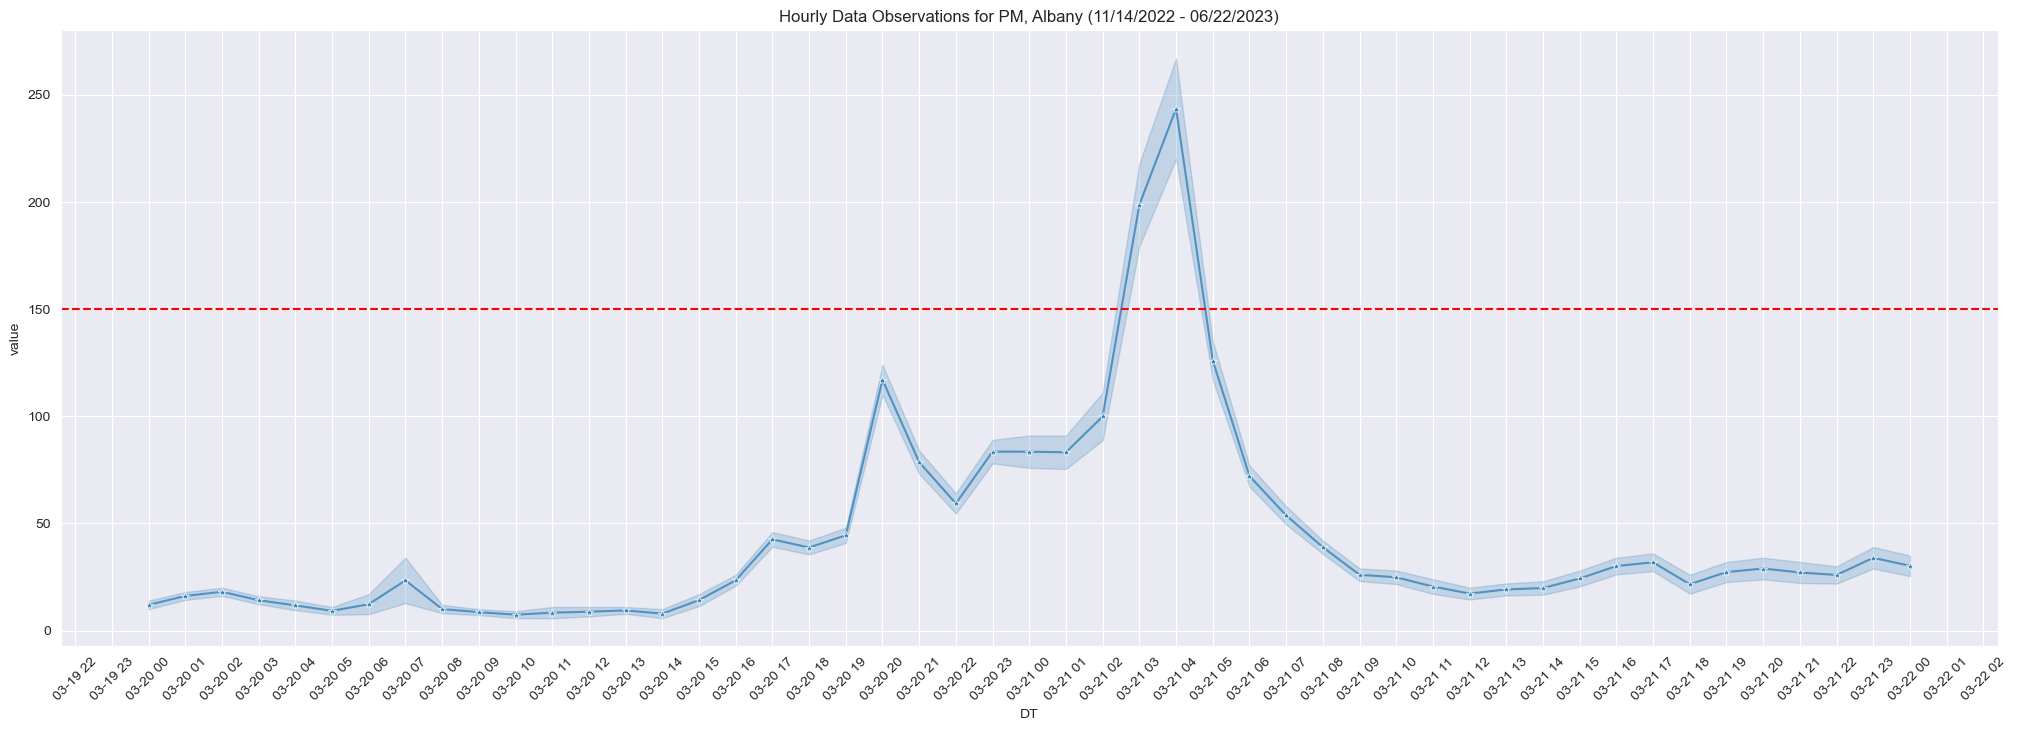

In [32]:
exceedance2 = hd[hd['DT'].between('2023-03-20', '2023-03-22')]
sns.set_style("darkgrid")

plt.figure(figsize=(25,8))
sns.lineplot(data=exceedance2, x='DT', y='value', alpha=0.7, linewidth=1.5, marker = '*').set_title("Hourly Data Observations for PM, Albany (11/14/2022 - 06/22/2023)")
plt.xticks(rotation=45)
plt.axhline(y=150, linestyle='dashed', color='red')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 

In [161]:
# subsetting different PMs from df

pm25 = hd.query('ParameterName == "PM2.5"')[['ValidDate','DT','value']].copy()
pm10 = hd.query('ParameterName == "PM10"')[['DT','value']].copy()

In [127]:
# looking at dates where PM25 values exceeded at some point or other
dates = pm25.query("Value > 35")['DT'].unique()
dates

<DatetimeArray>
['2022-11-18 14:00:00', '2022-11-18 16:00:00', '2022-11-20 00:00:00',
 '2022-11-20 01:00:00', '2022-12-30 02:00:00', '2022-12-30 23:00:00',
 '2023-01-07 01:00:00', '2023-01-08 01:00:00', '2023-01-08 06:00:00',
 '2023-01-08 07:00:00',
 ...
 '2023-03-23 09:00:00', '2023-03-23 10:00:00', '2023-03-23 11:00:00',
 '2023-03-23 17:00:00', '2023-03-23 18:00:00', '2023-03-23 19:00:00',
 '2023-03-23 20:00:00', '2023-03-24 02:00:00', '2023-05-18 12:00:00',
 '2023-05-18 13:00:00']
Length: 152, dtype: datetime64[ns]

In [186]:
# pm25_resampled = pm25.set_index('DT').resample("1D").mean()
dailyavg = pm25.groupby('ValidDate').mean().reset_index()
dailyavg['ValidDate'] = pd.to_datetime(dailyavg['ValidDate'])
dailyavg.set_index('ValidDate', inplace=True)
dailyavg = dailyavg['value']

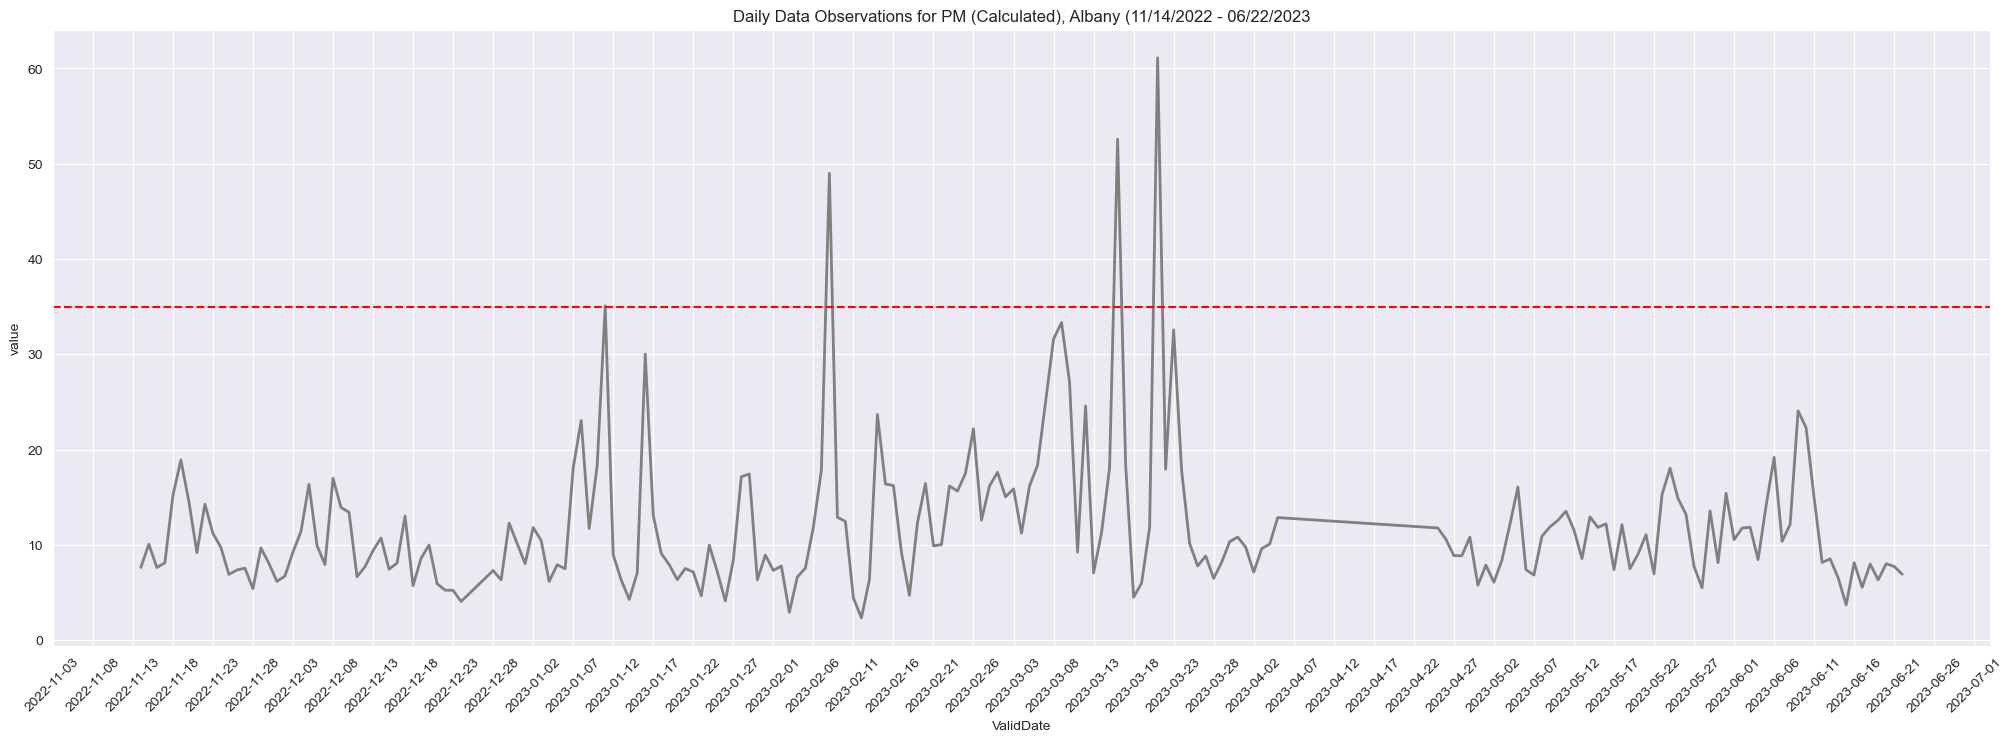

In [189]:
sns.set_style("darkgrid")

plt.figure(figsize=(25,8))
sns.lineplot(dailyavg, color='gray',linewidth=2).set_title("Daily Data Observations for PM (Calculated), Albany (11/14/2022 - 06/22/2023")
plt.xticks(rotation=45)
plt.axhline(y=35, linestyle='dashed', color='red')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5)) 